# 1 Load Data

In [1]:
import emd # https://emd.readthedocs.io/en/stable/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jupyter-tyo/2025/hht/emd/support.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # part of setuptoos


In [2]:
datasample = pd.read_csv("data_sample.csv") # digitized from https://web.eecs.utk.edu/~dcostine/personal/PowerDeviceLib/DigiTest/index.html
datasample

,time,amplitude
0,200.612939,-2.199720
1,200.725324,-2.426519
2,201.099941,-2.625799
3,201.605673,-2.848802
4,201.811712,-3.051640
...,...,...
753,594.147786,1.585168
754,594.953212,1.776144
755,595.871023,1.961931
756,596.788834,2.145642


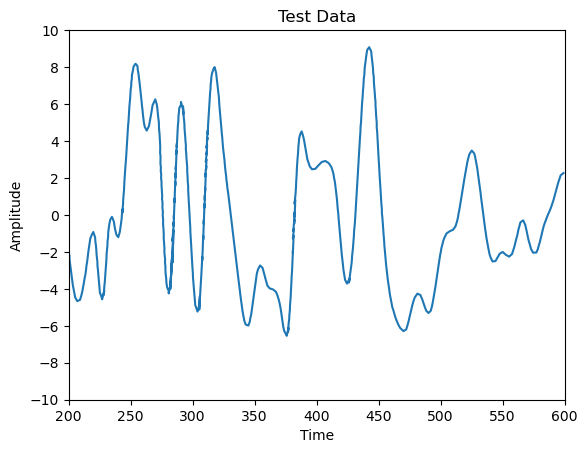

In [3]:
plt.plot(datasample['time'], datasample['amplitude'])
plt.title("Test Data")

plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# 2 EMD

In [4]:
# Define data (y) and time domain (t)
y = datasample['amplitude'].values # ubah variabel x->y
t = datasample['time'].values 
dt = np.mean(np.diff(t))       # average time step
fs = 1.0 / dt                  # sampling frequency (Hz)

In [5]:
# Envelope
uenv = emd.sift.interp_envelope(y, mode='upper', interp_method='splrep', ret_extrema=False) # array
lenv = emd.sift.interp_envelope(y, mode='lower', interp_method='splrep', ret_extrema=False) # array
aenv = (uenv+lenv) / 2

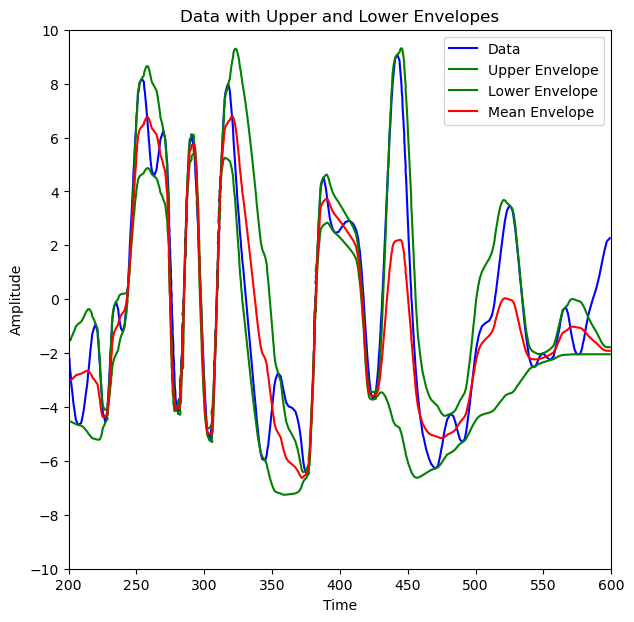

In [6]:
df = pd.DataFrame({
    'Data': y,
    'Upper Envelope': uenv,
    'Lower Envelope': lenv,
    'Mean Envelope': aenv,
    'time': t
})
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(df['time'], df['Data'], label='Data', color='blue')
ax.plot(df['time'], df['Upper Envelope'], label='Upper Envelope', color='green', linestyle='-')
ax.plot(df['time'], df['Lower Envelope'], label='Lower Envelope', color='green', linestyle='-')
ax.plot(df['time'], df['Mean Envelope'], label='Mean Envelope', color='red', linestyle='-')

plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title("Data with Upper and Lower Envelopes")
ax.legend()

plt.show()

## 2.1 Calculate IMFs with Iteration

In [7]:
def my_get_next_imf(x, t, zoom=None, sd_thresh=0.005):
    from scipy.signal import find_peaks

    signal = x.copy()  # Take a copy of the input so we don't overwrite anything
    continue_sift = True  # Define a flag indicating whether we should continue sifting
    niters = 0            # An iteration counter

    if zoom is None:
        zoom = (0, x.shape[0])

    # Main loop - we don't know how many iterations we'll need so we use a ``while`` loop
    while continue_sift:
        niters += 1  # Increment the counter
        
        # Compute upper and lower envelopes
        upper_env = emd.sift.interp_envelope(signal, mode='upper', interp_method='splrep')
        lower_env = emd.sift.interp_envelope(signal, mode='lower', interp_method='splrep')
        
        if upper_env is None or lower_env is None:
            print(f"[Iter {niters}] interp_envelope failed → fallback linear.")
            # manual envelope: gunakan scipy.signal.find_peaks
            idx_max = find_peaks(signal)[0]
            idx_min = find_peaks(-signal)[0]
            t_idx = np.arange(len(signal))

            if len(idx_max) < 2 or len(idx_min) < 2:
                print(f"[Iter {niters}] Too few extrema ({len(idx_max)}, {len(idx_min)}). Stop sifting.")
                break  # stop jika osilasi terlalu sedikit

            upper_env = np.interp(t_idx, idx_max, signal[idx_max])
            lower_env = np.interp(t_idx, idx_min, signal[idx_min])
            
        # Compute average envelope
        avg_env = (upper_env+lower_env) / 2

        # Add a summary subplot
        fig = plt.figure(figsize=(7, 80))   # set the figure size here
        ax = plt.subplot(12, 1, niters)     # create the subplot
        plt.plot(t, signal[zoom[0]:zoom[1]], 'k', label='h')
        plt.plot(t, upper_env[zoom[0]:zoom[1]], color='green', label='u_env')
        plt.plot(t, lower_env[zoom[0]:zoom[1]], color='green', label='l_env')
        plt.plot(t, avg_env[zoom[0]:zoom[1]], color='red', label='m')
        plt.yticks(np.arange(-10,11,2))
        plt.xlim(200, 600)
        plt.ylim(-12, 12)
        plt.legend()
        plt.title(f"Iterasi ke {niters}")

        # Should we stop sifting?
        stop, val = emd.sift.sd_stop(signal-avg_env, signal, sd=sd_thresh)

        # for the fist iteration, we don't have previous signal yet
        if niters == 1:
            previous_signal = signal
            
        # Remove envelope from signal -> update signal based on the previous iteration
        signal = previous_signal - avg_env

        # assign signal as a previous signal variable for the next iteration
        previous_signal = signal 
        
        # and finally, stop if we're stopping
        if stop:
            continue_sift = False

    # Return extracted IMF
    return signal

### 2.1.1 IMF1

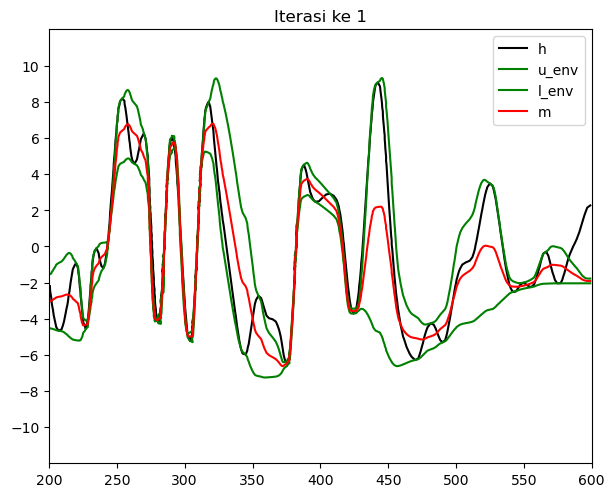

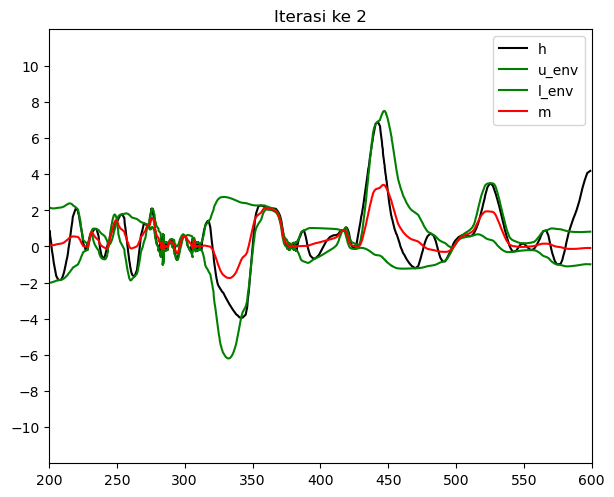

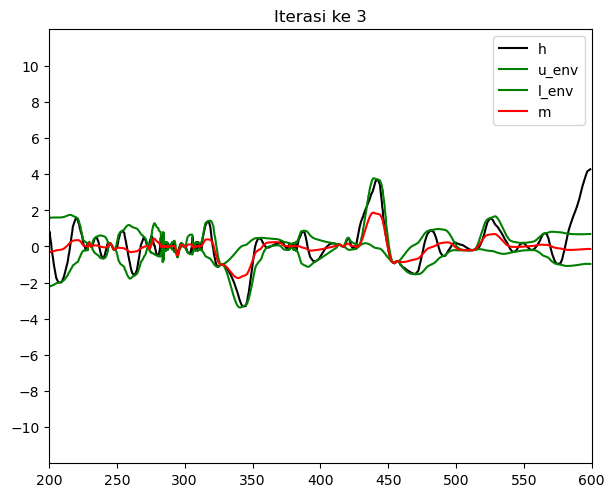

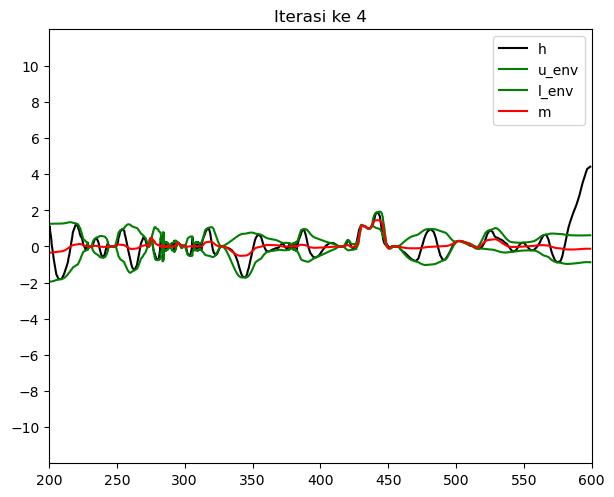

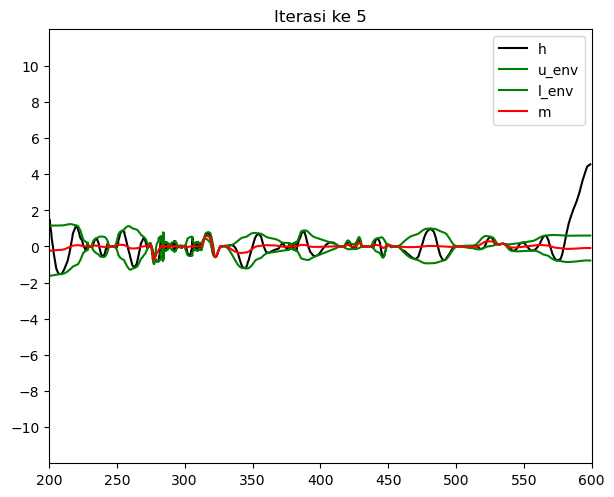

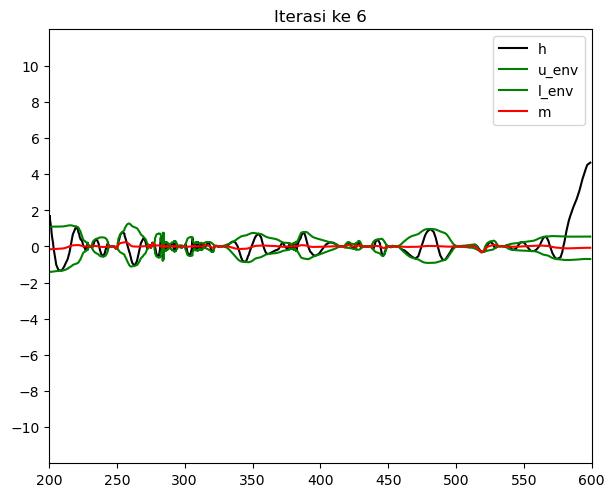

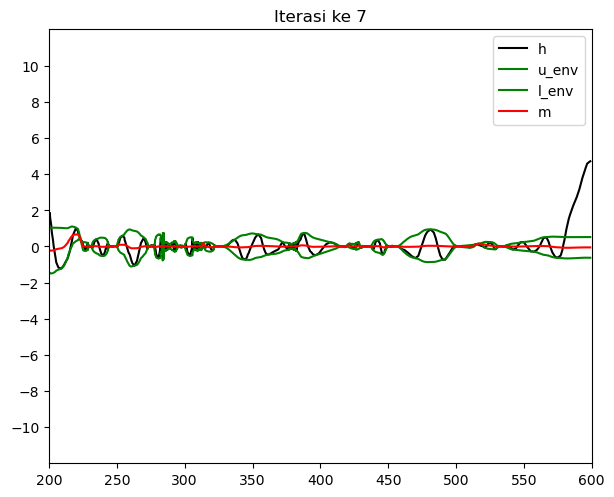

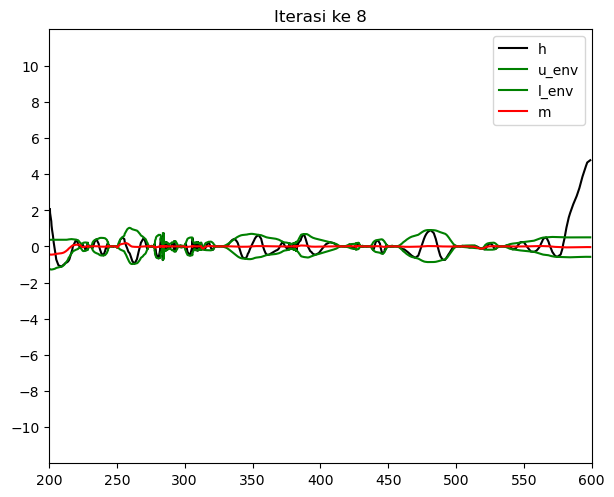

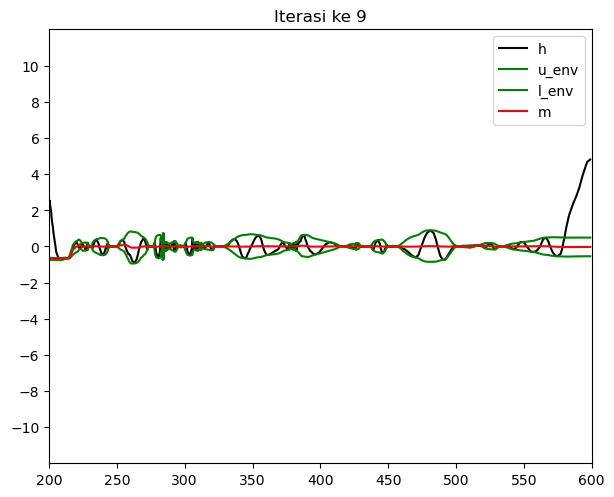

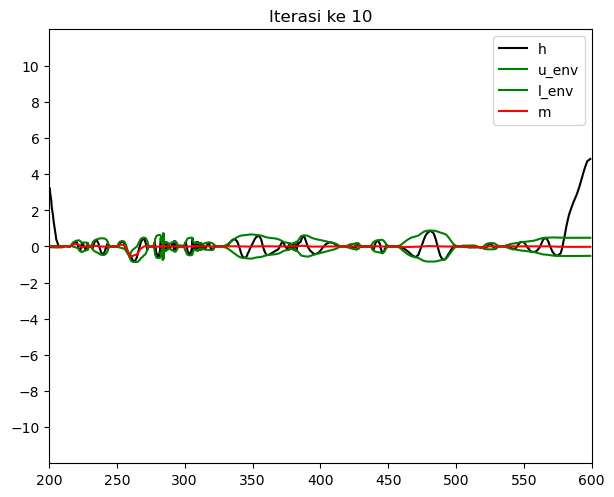

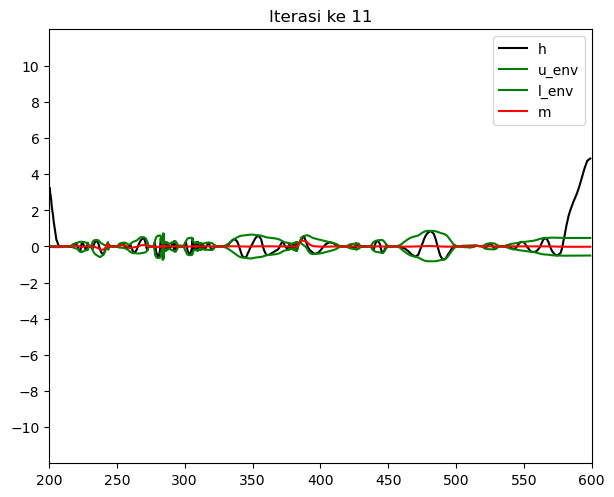

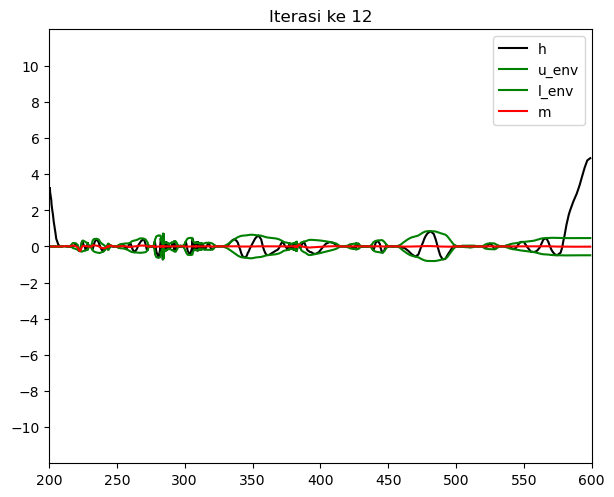

In [8]:
imf1 = my_get_next_imf(y, t) # plot sampai iterasi 12

([<matplotlib.axis.YTick at 0x7fa205923110>,
 [Text(0, -10, '−10'),
  Text(0, -8, '−8'),
  Text(0, -6, '−6'),
  Text(0, -4, '−4'),
  Text(0, -2, '−2'),
  Text(0, 0, '0'),
  Text(0, 2, '2'),
  Text(0, 4, '4'),
  Text(0, 6, '6'),
  Text(0, 8, '8'),
  Text(0, 10, '10')])

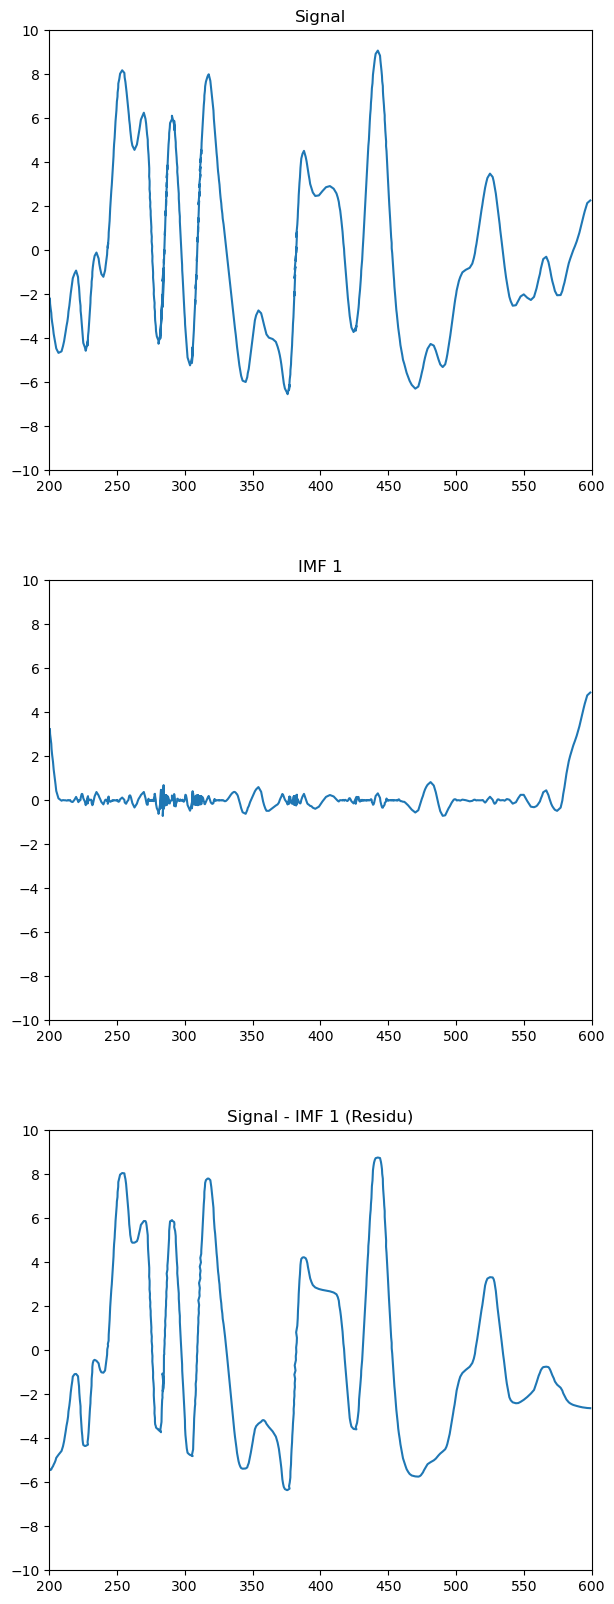

In [9]:
plt.figure(figsize=(7, 20))
plt.subplots_adjust(hspace=0.25)

plt.subplot(311)
plt.plot(t, y)
plt.title('Signal')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(312)
plt.plot(t, imf1)
plt.title('IMF 1')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(313)
plt.plot(t, y - imf1)
plt.title('Signal - IMF 1 (Residu)')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))

### 2.1.2 IMF2

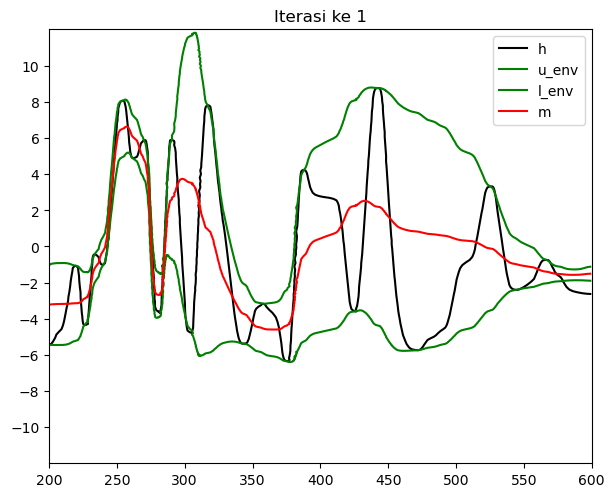

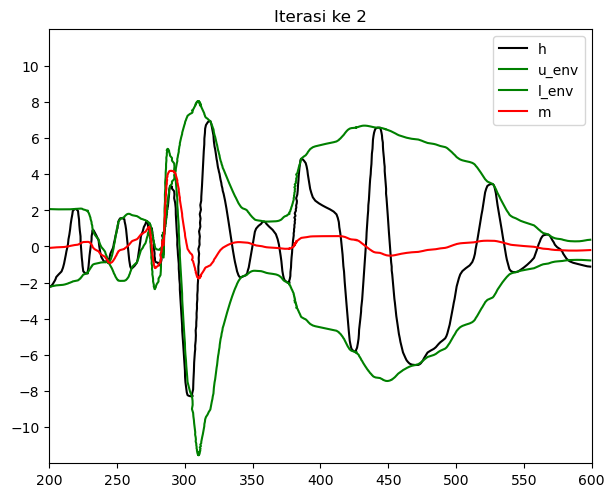

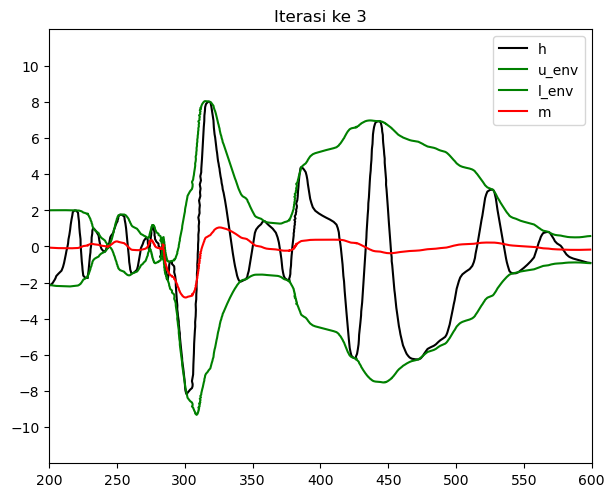

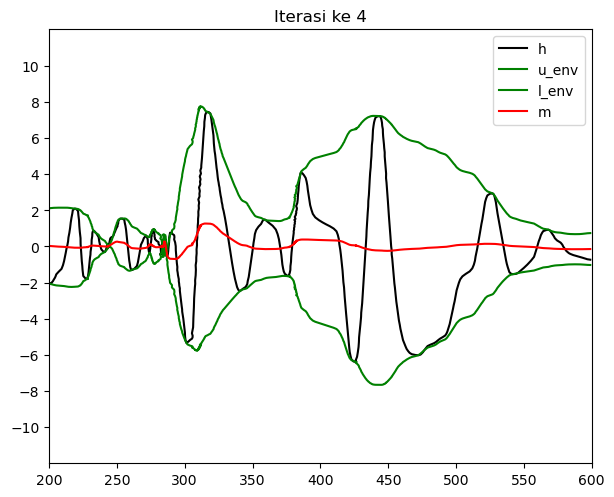

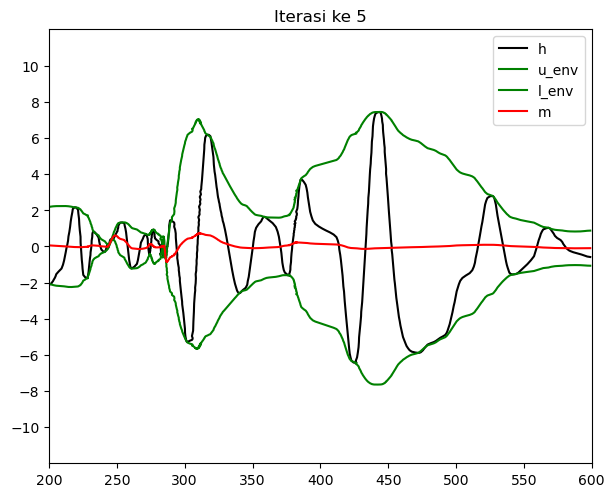

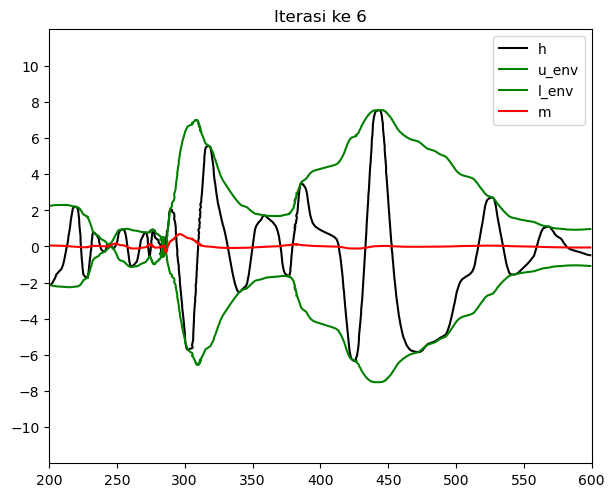

In [10]:
imf2 = my_get_next_imf(y - imf1, t)

([<matplotlib.axis.YTick at 0x7fa20550c7d0>,
 [Text(0, -10, '−10'),
  Text(0, -8, '−8'),
  Text(0, -6, '−6'),
  Text(0, -4, '−4'),
  Text(0, -2, '−2'),
  Text(0, 0, '0'),
  Text(0, 2, '2'),
  Text(0, 4, '4'),
  Text(0, 6, '6'),
  Text(0, 8, '8'),
  Text(0, 10, '10')])

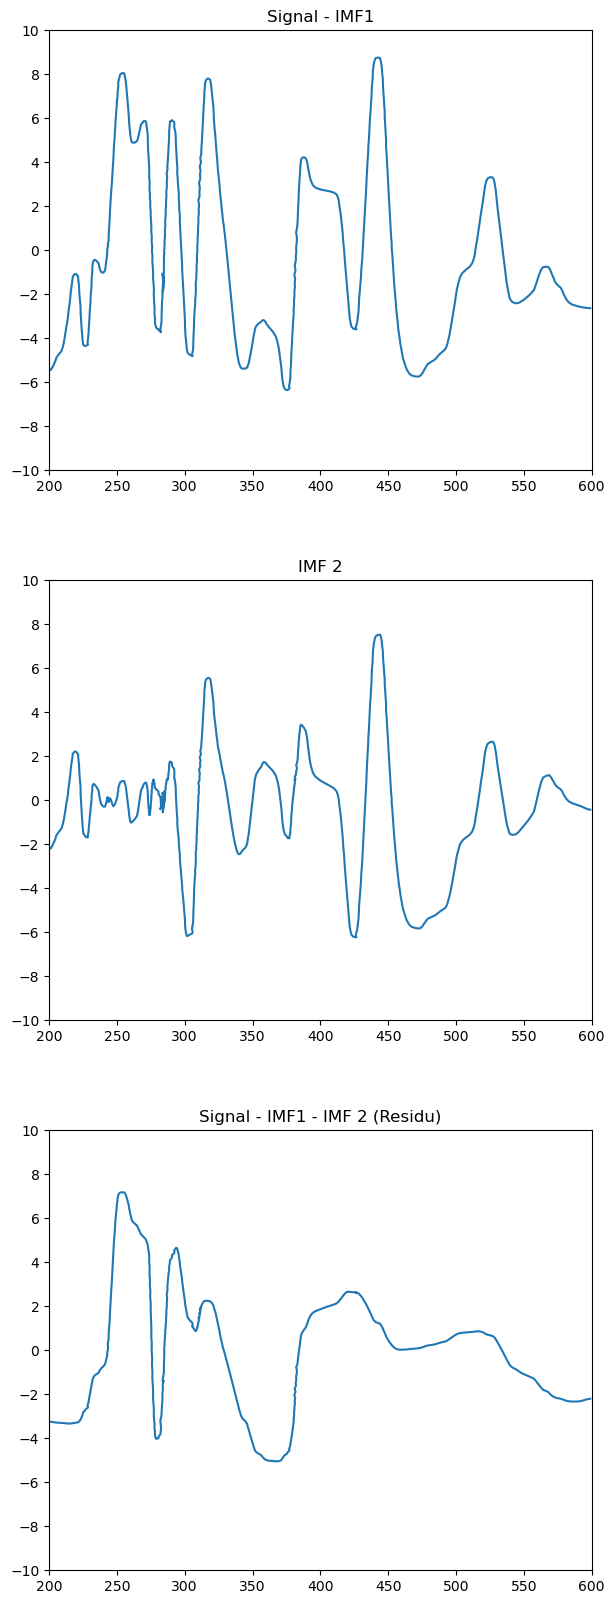

In [11]:
plt.figure(figsize=(7, 20))
plt.subplots_adjust(hspace=0.25)

plt.subplot(311)
plt.plot(t, y - imf1)
plt.title('Signal - IMF1')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(312)
plt.plot(t, imf2)
plt.title('IMF 2')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(313)
plt.plot(t, y - imf1 - imf2)
plt.title('Signal - IMF1 - IMF 2 (Residu)')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))

### 2.1.3 IMF3

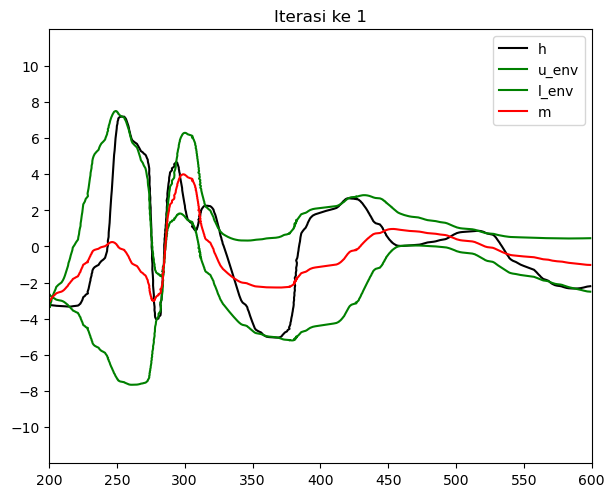

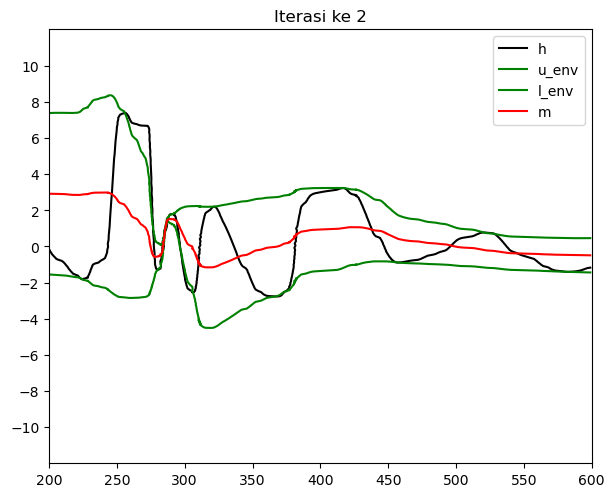

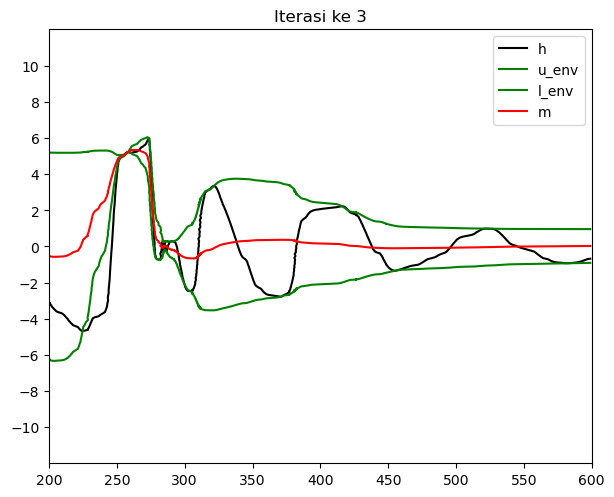

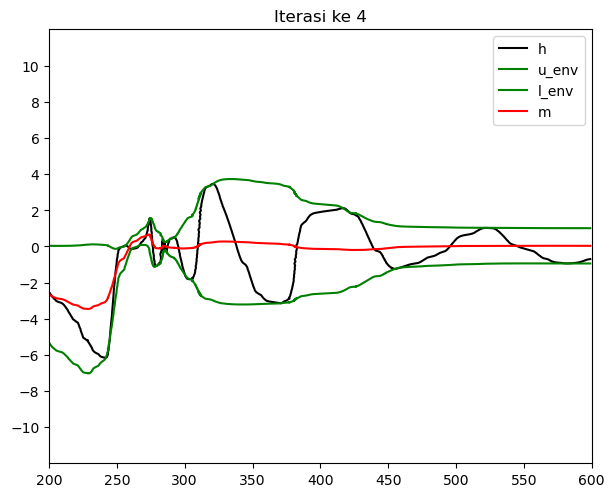

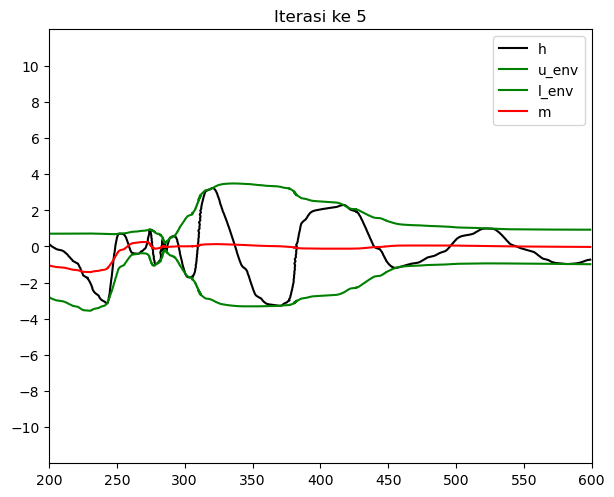

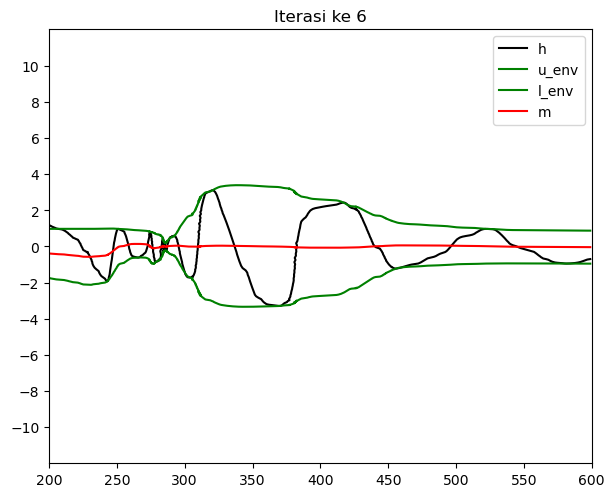

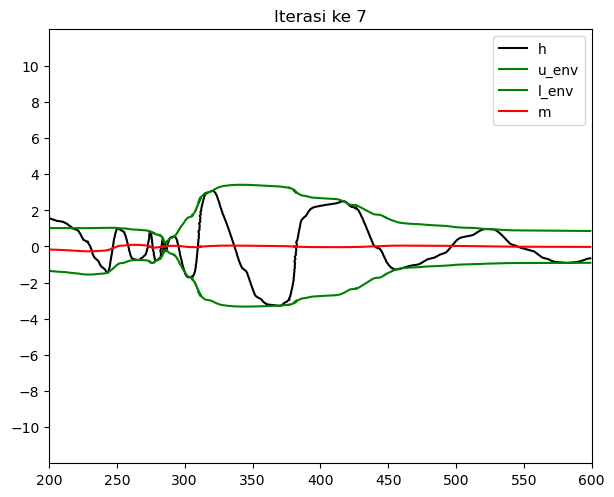

In [12]:
imf3 = my_get_next_imf(y - imf1 - imf2, t)

([<matplotlib.axis.YTick at 0x7fa2043d1d10>,
 [Text(0, -10, '−10'),
  Text(0, -8, '−8'),
  Text(0, -6, '−6'),
  Text(0, -4, '−4'),
  Text(0, -2, '−2'),
  Text(0, 0, '0'),
  Text(0, 2, '2'),
  Text(0, 4, '4'),
  Text(0, 6, '6'),
  Text(0, 8, '8'),
  Text(0, 10, '10')])

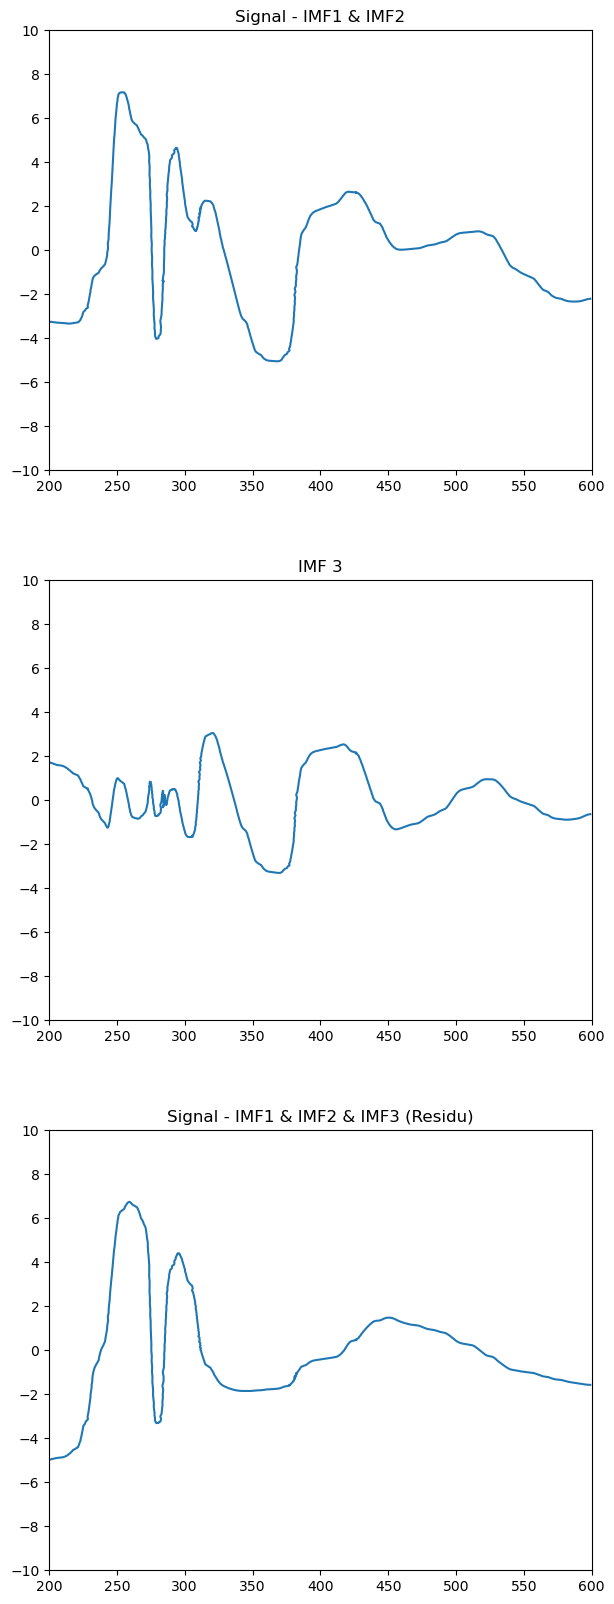

In [13]:
plt.figure(figsize=(7, 20))
plt.subplots_adjust(hspace=0.25)

plt.subplot(311)
plt.plot(t, y - imf1 - imf2)
plt.title('Signal - IMF1 & IMF2')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(312)
plt.plot(t, imf3)
plt.title('IMF 3')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(313)
plt.plot(t, y - imf1 - imf2 - imf3)
plt.title('Signal - IMF1 & IMF2 & IMF3 (Residu)')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))

### 2.1.4 IMF4

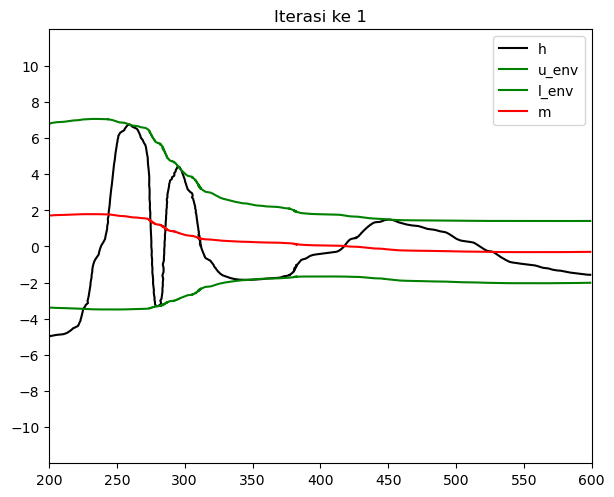

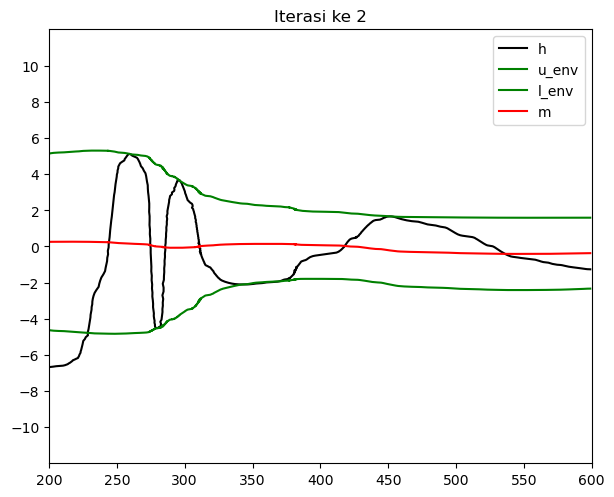

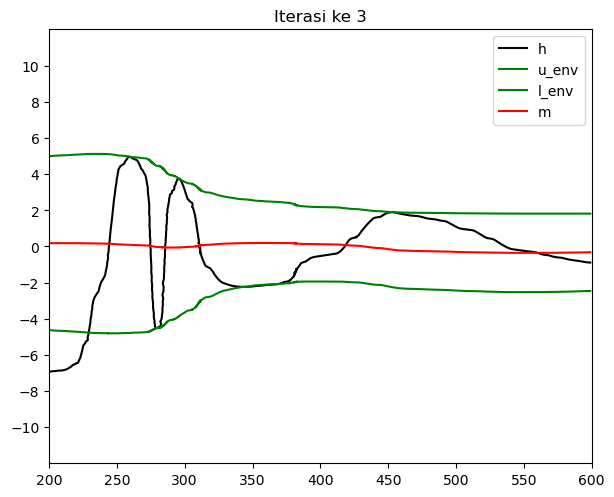

In [14]:
imf4 = my_get_next_imf(y - imf1 - imf2 - imf3, t)

([<matplotlib.axis.YTick at 0x7fa207787250>,
 [Text(0, -10, '−10'),
  Text(0, -8, '−8'),
  Text(0, -6, '−6'),
  Text(0, -4, '−4'),
  Text(0, -2, '−2'),
  Text(0, 0, '0'),
  Text(0, 2, '2'),
  Text(0, 4, '4'),
  Text(0, 6, '6'),
  Text(0, 8, '8'),
  Text(0, 10, '10')])

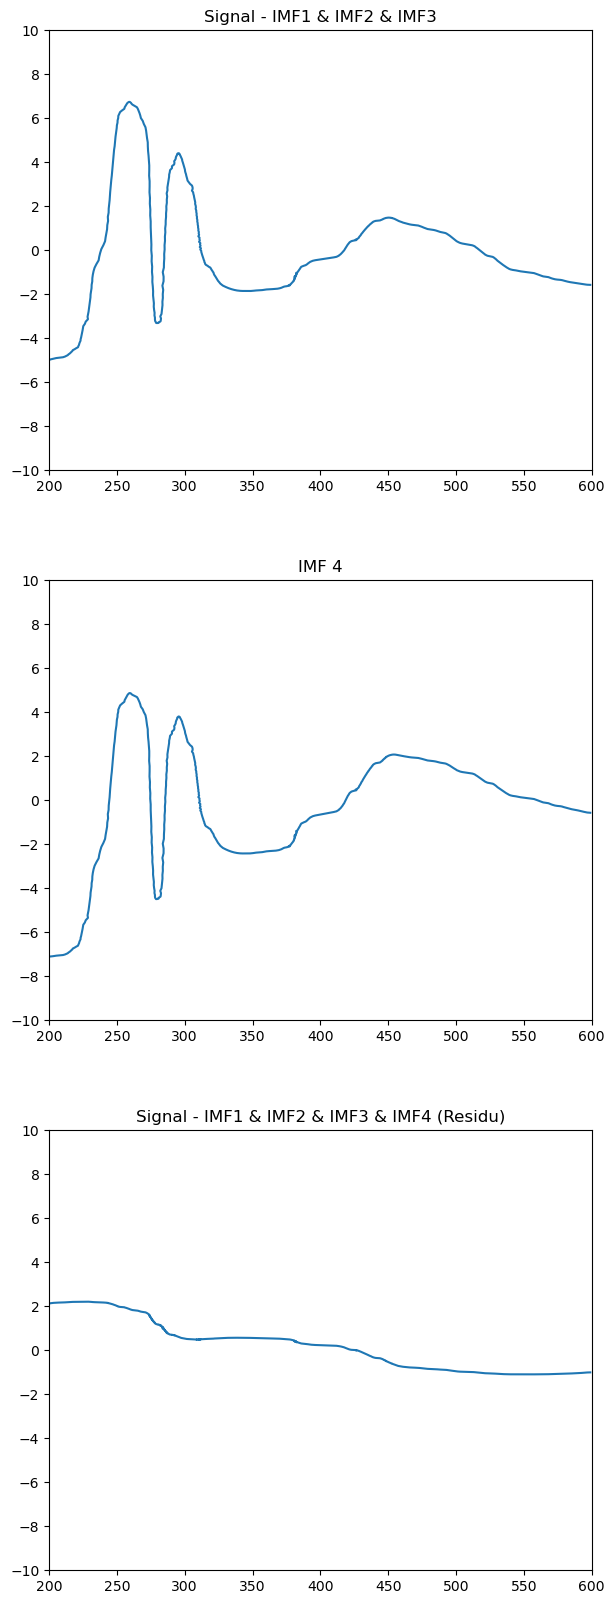

In [15]:
plt.figure(figsize=(7, 20))
plt.subplots_adjust(hspace=0.25)

plt.subplot(311)
plt.plot(t, y - imf1 - imf2 - imf3)
plt.title('Signal - IMF1 & IMF2 & IMF3')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(312)
plt.plot(t, imf4)
plt.title('IMF 4')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(313)
plt.plot(t, y - imf1 - imf2 - imf3 - imf4)
plt.title('Signal - IMF1 & IMF2 & IMF3 & IMF4 (Residu)')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))

### 2.1.5 IMF5

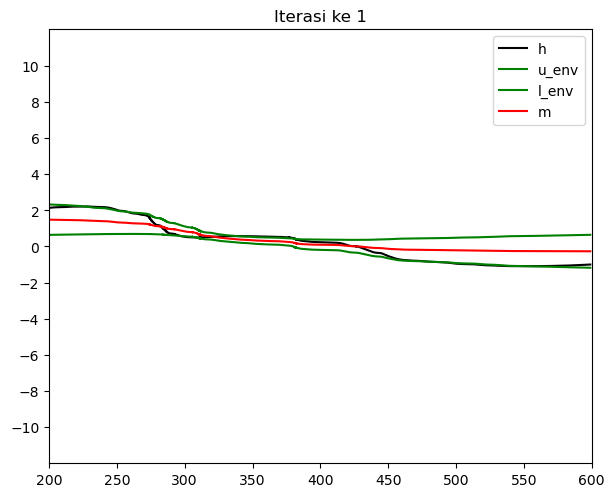

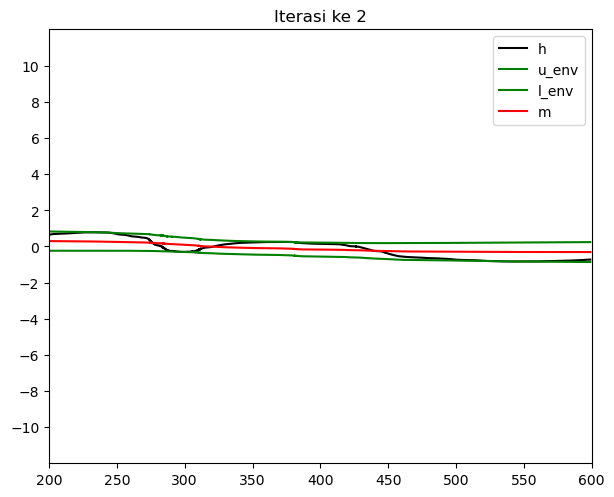

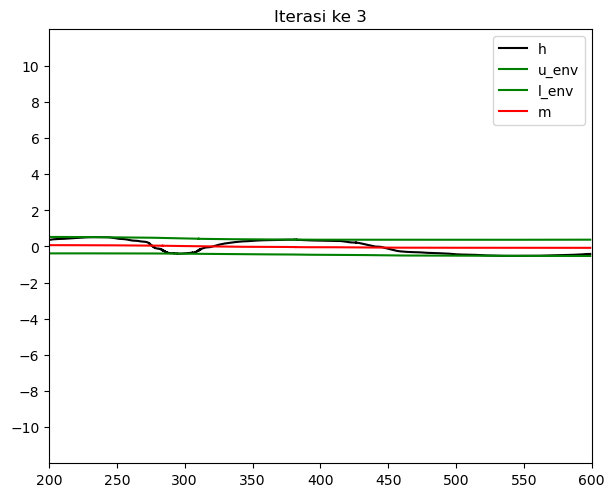

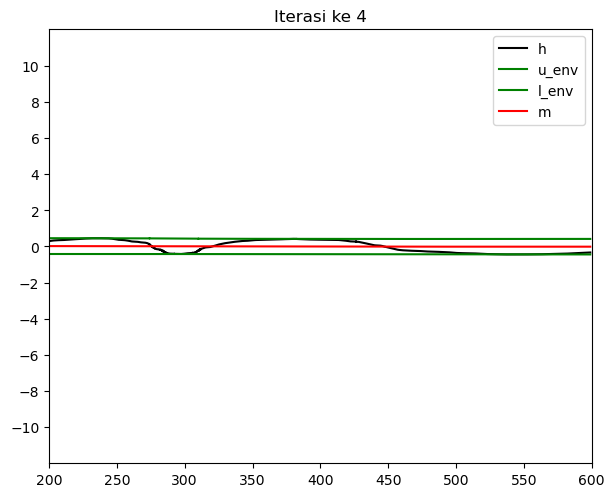

In [16]:
imf5 = my_get_next_imf(y - imf1 - imf2 - imf3 - imf4, t)

([<matplotlib.axis.YTick at 0x7fa205e2fed0>,
 [Text(0, -10, '−10'),
  Text(0, -8, '−8'),
  Text(0, -6, '−6'),
  Text(0, -4, '−4'),
  Text(0, -2, '−2'),
  Text(0, 0, '0'),
  Text(0, 2, '2'),
  Text(0, 4, '4'),
  Text(0, 6, '6'),
  Text(0, 8, '8'),
  Text(0, 10, '10')])

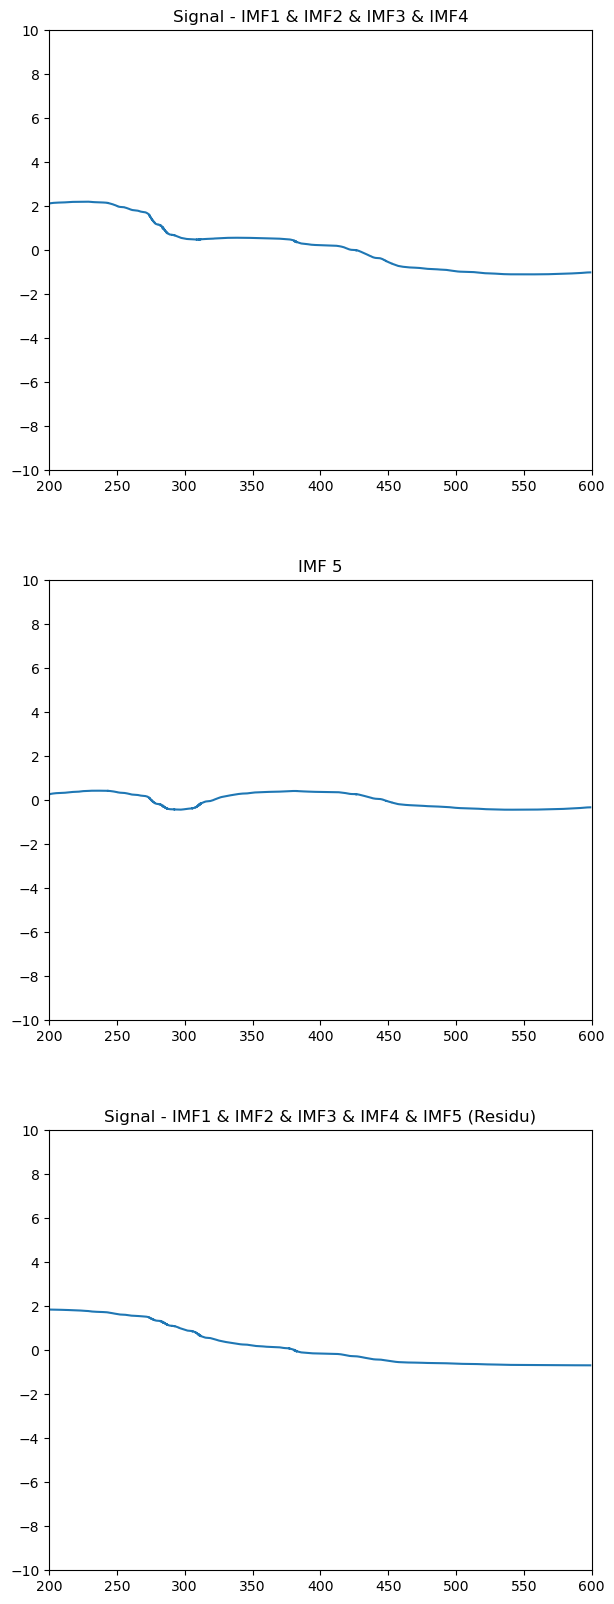

In [17]:
plt.figure(figsize=(7, 20))
plt.subplots_adjust(hspace=0.25)

plt.subplot(311)
plt.plot(t, y - imf1 - imf2 - imf3 - imf4)
plt.title('Signal - IMF1 & IMF2 & IMF3 & IMF4')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(312)
plt.plot(t, imf5)
plt.title('IMF 5')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))
plt.subplot(313)
plt.plot(t, y - imf1 - imf2 - imf3 - imf4 - imf5)
plt.title('Signal - IMF1 & IMF2 & IMF3 & IMF4 & IMF5 (Residu)')
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.yticks(np.arange(-10,11,2))

### 2.1.6 IMF6

In [18]:
imf6 = my_get_next_imf(y - imf1 - imf2 - imf3 - imf4 - imf5, t) # IMF terhenti di IMF5 karena setelahnya sudah tidak ada nilai ekstrem

[Iter 1] interp_envelope failed → fallback linear.
[Iter 1] Too few extrema (0, 0). Stop sifting.


## 2.2 Calculate IMFs with Embedded Function

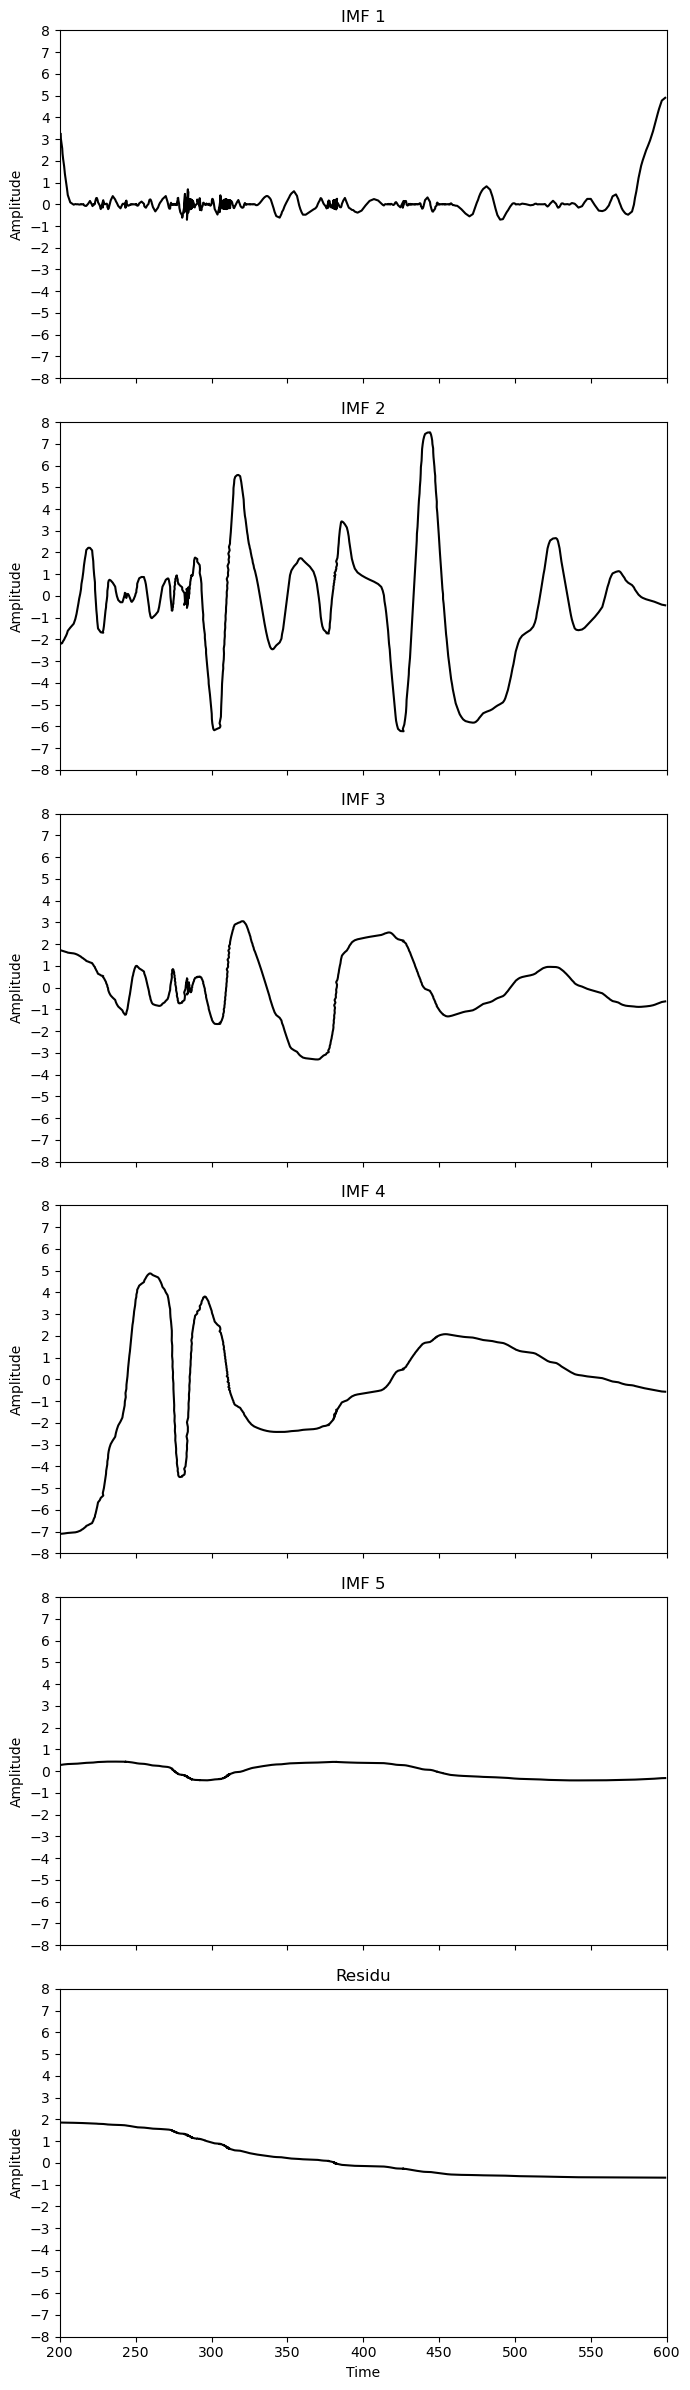

In [19]:
imf = emd.sift.sift(y, imf_opts={'sd_thresh': 0.005}, envelope_opts={'interp_method':'splrep'}) # threshold diubah diseragamkan
n_imfs = imf.shape[1]

fig, axes = plt.subplots(n_imfs, 1, figsize=(7, 4*n_imfs), sharex=True)

if n_imfs == 1:
    axes = [axes]  # make iterable if only one IMF

for i in range(n_imfs):
    axes[i].plot(t, imf[:, i], color='black')
    axes[i].set_xlim(200, 600)
    axes[i].set_ylim(-8, 8)
    axes[i].set_yticks(np.arange(-8,9,1))
    axes[i].set_ylabel("Amplitude")
    if i == n_imfs-1:
        axes[i].set_title(f"Residu")
    else:
        axes[i].set_title(f"IMF {i+1}")
    
axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

# 3 Hilbert Transform - 2d (time-frequency)

In [20]:
IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')

## 3.1 IMF1

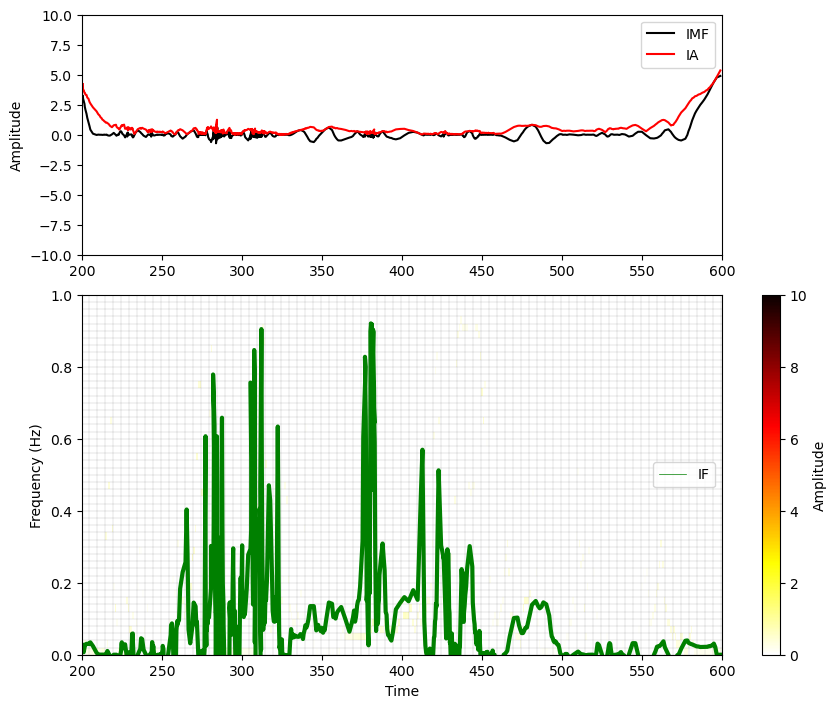

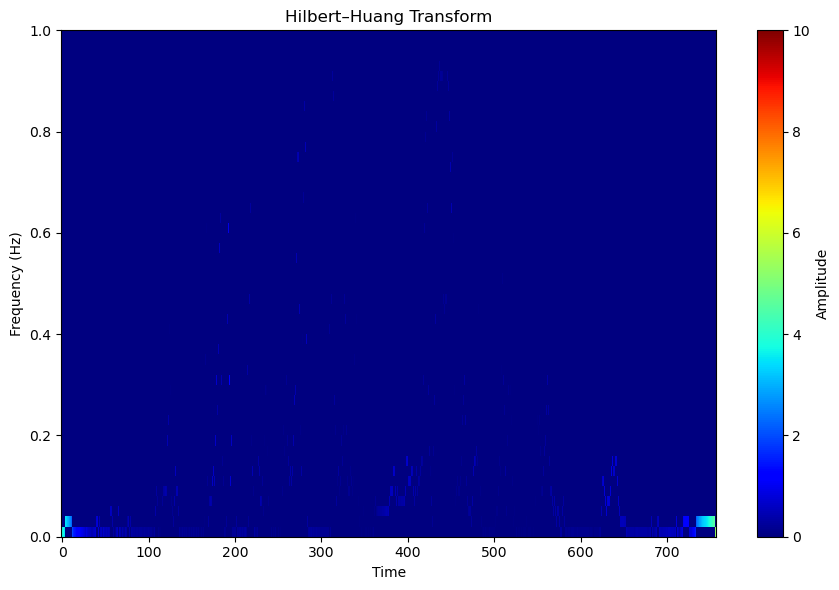

In [21]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 1, 50, 'linear')

hht = emd.spectra.hilberthuang(IF[:, 0, None], IA[:, 0, None], freq_edges, mode='amplitude')

time_centres = np.arange(hht.shape[1]) - 0.5
time_edges = np.arange(hht.shape[1] + 1) - 0.5

plt.figure(figsize=(10, 8))

# IMF and IA
plt.axes([.1, .6, .64, .3])
plt.plot(t, imf[:, 0], 'k')
plt.plot(t, IA[:, 0], 'r')
plt.legend(['IMF', 'IA'])
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.ylabel('Amplitude')

# IF
plt.axes([.1, .1, .8, .45])
plt.plot(t, IF[:, 0], 'g', linewidth=0.5)
plt.legend(['IF'])

plt.ylabel('Frequency (Hz)')

# HHT
plt.pcolormesh(time_edges, freq_edges, hht, cmap='hot_r', shading='auto', vmin=0, vmax=10)

# Colorbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

for f in freq_edges:
    plt.axhline(f, color='k', linewidth=0.3, alpha=0.25)
for tt in time_edges[::5]:
    plt.axvline(tt, color='k', linewidth=0.3, alpha=0.25)

# Overlay IF
plt.plot(t, IF[:, 0], 'g', linewidth=3)

plt.xlim(200, 600)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')

plt.figure(figsize=(9, 6))
plt.pcolormesh(time_centres, freq_centres, hht, cmap='jet', shading='auto', vmin=0, vmax=10)
plt.title('Hilbert–Huang Transform')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

## 3.2 IMF2

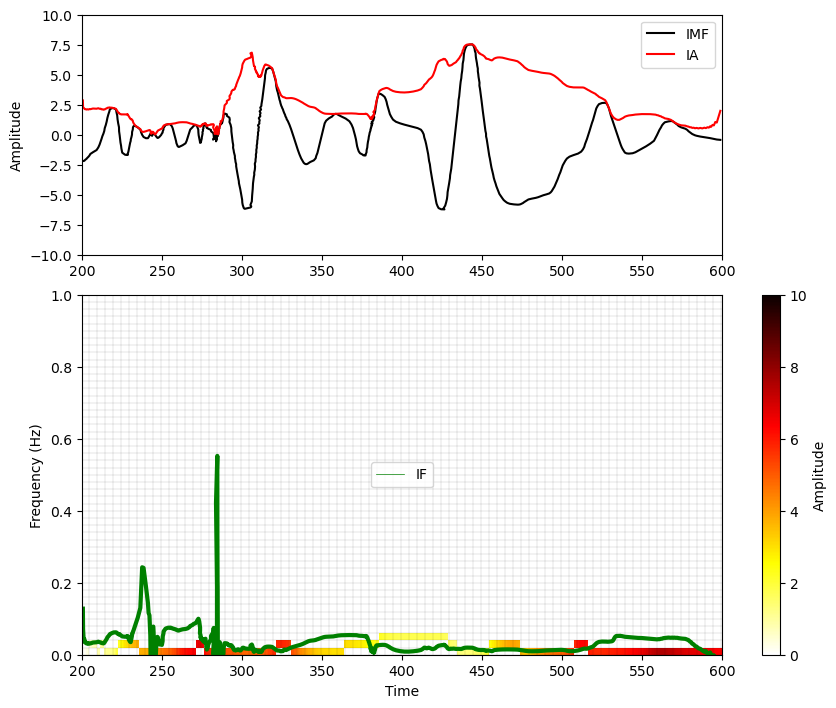

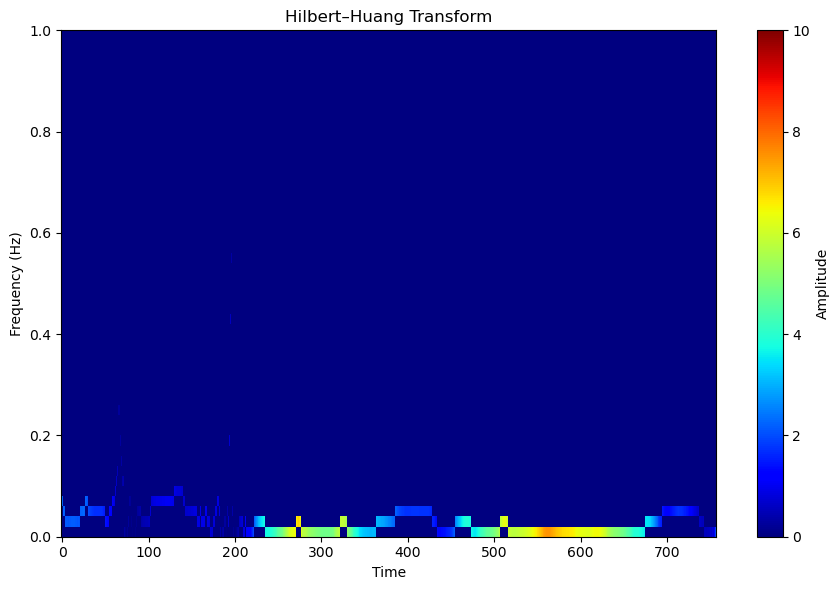

In [22]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 1, 50, 'linear')

hht = emd.spectra.hilberthuang(IF[:, 1, None], IA[:, 1, None], freq_edges, mode='amplitude')

time_centres = np.arange(hht.shape[1]) - 0.5
time_edges = np.arange(hht.shape[1] + 1) - 0.5

plt.figure(figsize=(10, 8))

# IMF and IA
plt.axes([.1, .6, .64, .3])
plt.plot(t, imf[:, 1], 'k')
plt.plot(t, IA[:, 1], 'r')
plt.legend(['IMF', 'IA'])
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.ylabel('Amplitude')

# IF
plt.axes([.1, .1, .8, .45])
plt.plot(t, IF[:, 1], 'g', linewidth=0.5)
plt.legend(['IF'])

# HHT
plt.pcolormesh(time_edges, freq_edges, hht, cmap='hot_r', shading='auto', vmin=0, vmax=10)

# Colorbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

for f in freq_edges:
    plt.axhline(f, color='k', linewidth=0.3, alpha=0.25)
for tt in time_edges[::5]:
    plt.axvline(tt, color='k', linewidth=0.3, alpha=0.25)

# Overlay IF
plt.plot(t, IF[:, 1], 'g', linewidth=3)

plt.xlim(200, 600)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')

plt.figure(figsize=(9, 6))
plt.pcolormesh(time_centres, freq_centres, hht, cmap='jet', shading='auto', vmin=0, vmax=10)
plt.title('Hilbert–Huang Transform')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

## 3.3 IMF3

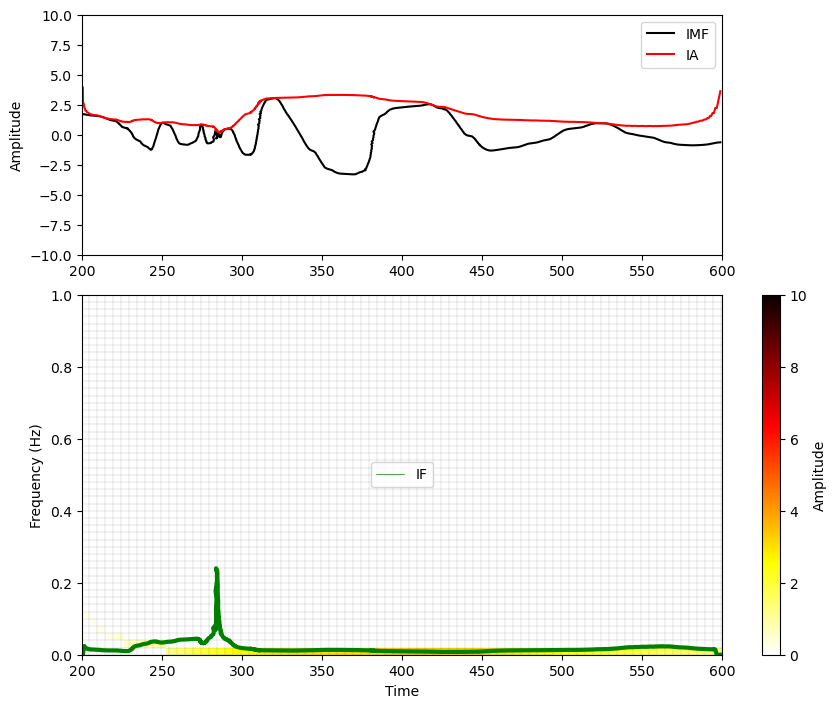

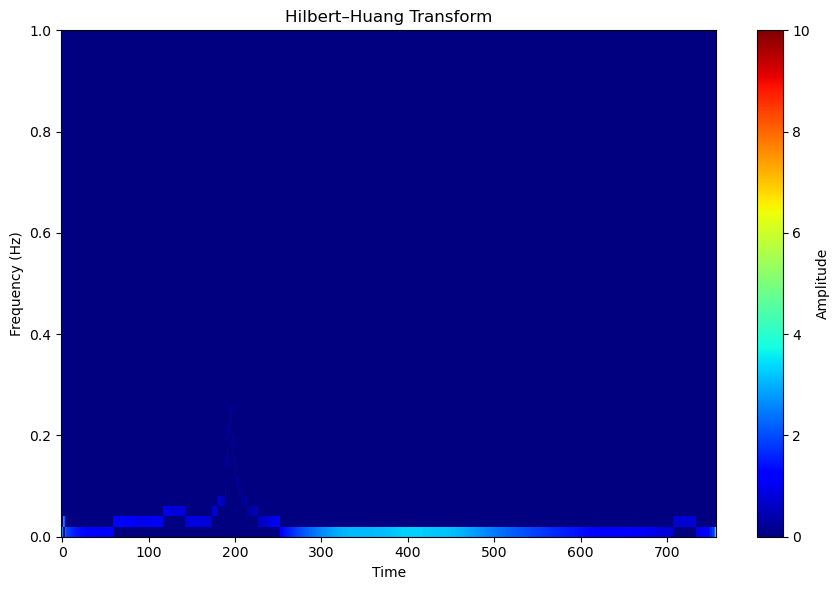

In [23]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 1, 50, 'linear')

hht = emd.spectra.hilberthuang(IF[:, 2, None], IA[:, 2, None], freq_edges, mode='amplitude')

time_centres = np.arange(hht.shape[1]) - 0.5
time_edges = np.arange(hht.shape[1] + 1) - 0.5

plt.figure(figsize=(10, 8))

# IMF and IA
plt.axes([.1, .6, .64, .3])
plt.plot(t, imf[:, 2], 'k')
plt.plot(t, IA[:, 2], 'r')
plt.legend(['IMF', 'IA'])
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.ylabel('Amplitude')

# IF
plt.axes([.1, .1, .8, .45])
plt.plot(t, IF[:, 2], 'g', linewidth=0.5)
plt.legend(['IF'])

# HHT
plt.pcolormesh(time_edges, freq_edges, hht, cmap='hot_r', shading='auto', vmin=0, vmax=10)

# Colorbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

for f in freq_edges:
    plt.axhline(f, color='k', linewidth=0.3, alpha=0.25)
for tt in time_edges[::5]:
    plt.axvline(tt, color='k', linewidth=0.3, alpha=0.25)

# Overlay IF
plt.plot(t, IF[:, 2], 'g', linewidth=3)

plt.xlim(200, 600)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')

plt.figure(figsize=(9, 6))
plt.pcolormesh(time_centres, freq_centres, hht, cmap='jet', shading='auto', vmin=0, vmax=10)
plt.title('Hilbert–Huang Transform')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

## 3.4 IMF4

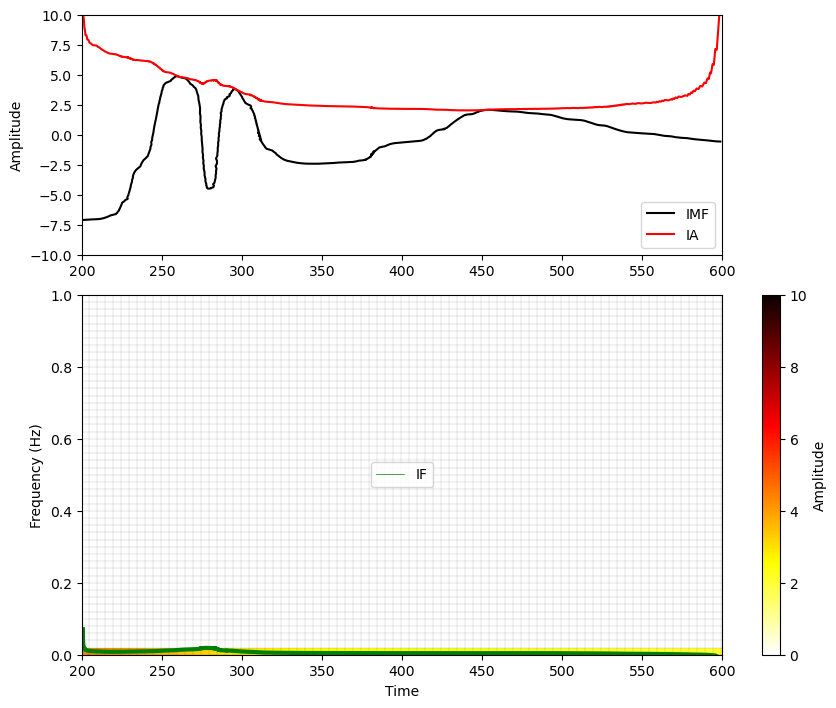

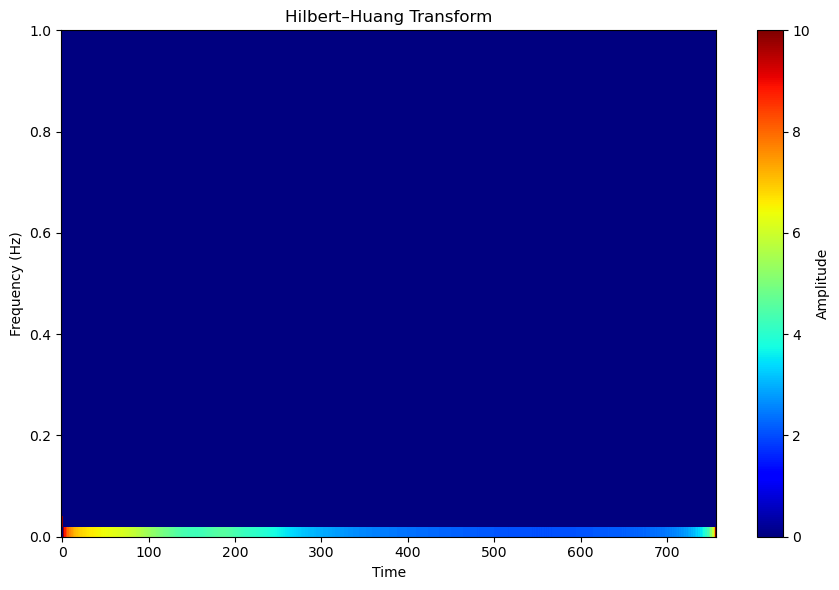

In [24]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 1, 50, 'linear')

hht = emd.spectra.hilberthuang(IF[:, 3, None], IA[:, 3, None], freq_edges, mode='amplitude')

time_centres = np.arange(hht.shape[1]) - 0.5
time_edges = np.arange(hht.shape[1] + 1) - 0.5

plt.figure(figsize=(10, 8))

# IMF and IA
plt.axes([.1, .6, .64, .3])
plt.plot(t, imf[:, 3], 'k')
plt.plot(t, IA[:, 3], 'r')
plt.legend(['IMF', 'IA'])
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.ylabel('Amplitude')

# IF
plt.axes([.1, .1, .8, .45])
plt.plot(t, IF[:, 3], 'g', linewidth=0.5)
plt.legend(['IF'])

# HHT
plt.pcolormesh(time_edges, freq_edges, hht, cmap='hot_r', shading='auto', vmin=0, vmax=10)

# Colorbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

for f in freq_edges:
    plt.axhline(f, color='k', linewidth=0.3, alpha=0.25)
for tt in time_edges[::5]:
    plt.axvline(tt, color='k', linewidth=0.3, alpha=0.25)

# Overlay IF
plt.plot(t, IF[:, 3], 'g', linewidth=3)

plt.xlim(200, 600)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')

plt.figure(figsize=(9, 6))
plt.pcolormesh(time_centres, freq_centres, hht, cmap='jet', shading='auto', vmin=0, vmax=10)
plt.title('Hilbert–Huang Transform')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

## 3.5 IMF5

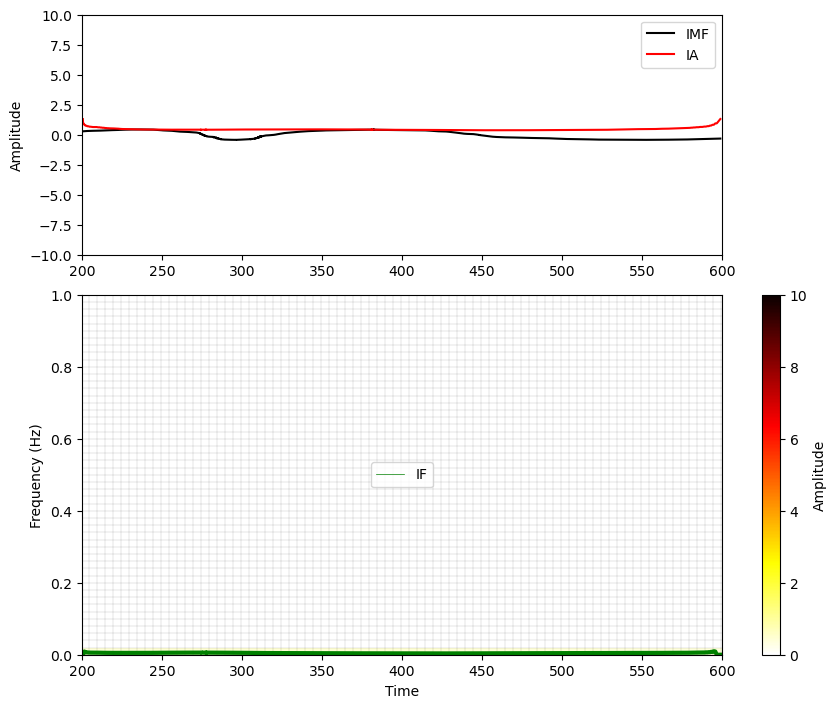

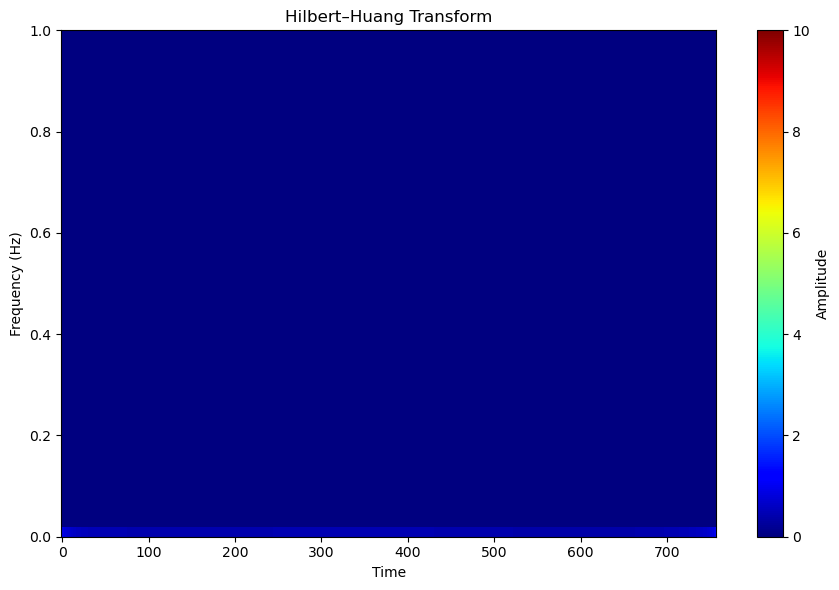

In [25]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 1, 50, 'linear')

hht = emd.spectra.hilberthuang(IF[:, 4, None], IA[:, 4, None], freq_edges, mode='amplitude')

time_centres = np.arange(hht.shape[1]) - 0.5
time_edges = np.arange(hht.shape[1] + 1) - 0.5

plt.figure(figsize=(10, 8))

# IMF and IA
plt.axes([.1, .6, .64, .3])
plt.plot(t, imf[:, 4], 'k')
plt.plot(t, IA[:, 4], 'r')
plt.legend(['IMF', 'IA'])
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.ylabel('Amplitude')

# IF
plt.axes([.1, .1, .8, .45])
plt.plot(t, IF[:, 4], 'g', linewidth=0.5)
plt.legend(['IF'])

# HHT
plt.pcolormesh(time_edges, freq_edges, hht, cmap='hot_r', shading='auto', vmin=0, vmax=10)

# Colorbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

for f in freq_edges:
    plt.axhline(f, color='k', linewidth=0.3, alpha=0.25)
for tt in time_edges[::5]:
    plt.axvline(tt, color='k', linewidth=0.3, alpha=0.25)

# Overlay IF
plt.plot(t, IF[:, 4], 'g', linewidth=3)

plt.xlim(200, 600)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')

plt.figure(figsize=(9, 6))
plt.pcolormesh(time_centres, freq_centres, hht, cmap='jet', shading='auto', vmin=0, vmax=10)
plt.title('Hilbert–Huang Transform')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

## 3.2 Full IMFs

In [26]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 0.6, 50, 'linear')
hhtfull = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude')
time_centres = np.arange(hhtfull.shape[1]) - 0.5
time_edges = np.arange(hhtfull.shape[1] + 1) - 0.5


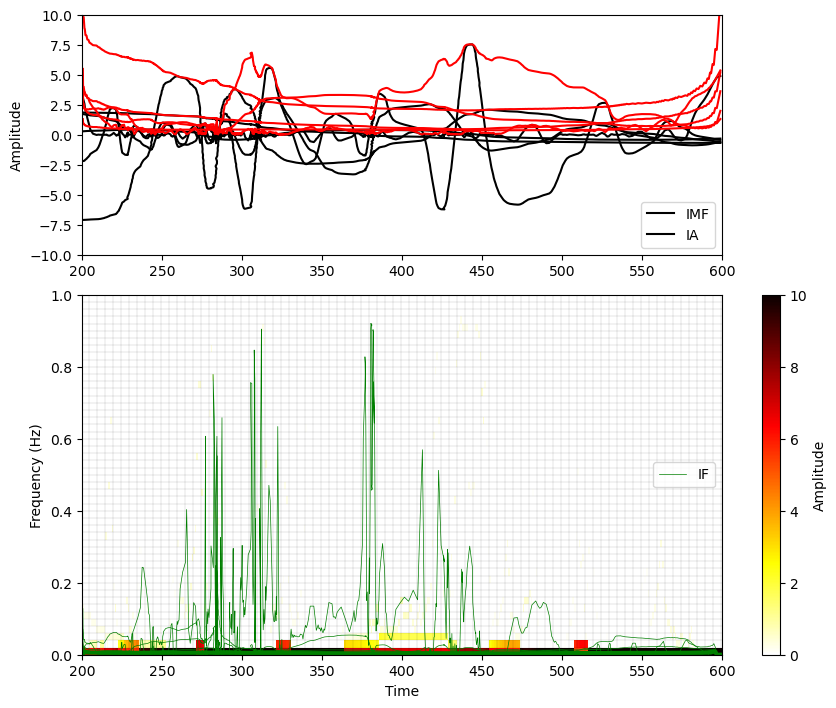

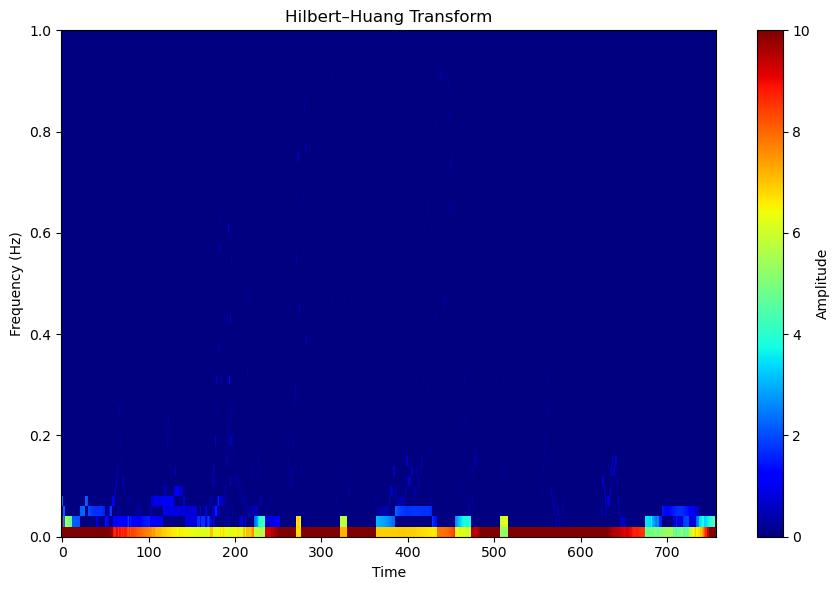

In [27]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 1, 50, 'linear')

hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude')

time_centres = np.arange(hht.shape[1]) - 0.5
time_edges = np.arange(hht.shape[1] + 1) - 0.5

plt.figure(figsize=(10, 8))

# IMF and IA
plt.axes([.1, .6, .64, .3])
plt.plot(t, imf, 'k')
plt.plot(t, IA, 'r')
plt.legend(['IMF', 'IA'])
plt.xlim(200, 600)
plt.ylim(-10, 10)
plt.ylabel('Amplitude')

# IF
plt.axes([.1, .1, .8, .45])
plt.plot(t, IF, 'g', linewidth=0.5)
plt.legend(['IF'])

# HHT
plt.pcolormesh(time_edges, freq_edges, hht, cmap='hot_r', shading='auto', vmin=0, vmax=10)

# Colorbar
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

for f in freq_edges:
    plt.axhline(f, color='k', linewidth=0.3, alpha=0.25)
for tt in time_edges[::5]:
    plt.axvline(tt, color='k', linewidth=0.3, alpha=0.25)

# Overlay IF
plt.plot(t, IF[:, 4], 'g', linewidth=3)

plt.xlim(200, 600)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')

plt.figure(figsize=(9, 6))
plt.pcolormesh(time_centres, freq_centres, hht, cmap='jet', shading='auto', vmin=0, vmax=10)
plt.title('Hilbert–Huang Transform')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

# 4 Hilbert Transform - 1d (frequency)

In [28]:
IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')

In [29]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 50, 8, 'log')

# We round the values to 3dp for easier visualisation
print('Bin Edges:   {0}'.format(np.round(freq_edges, 3)))
print('Bin Centres: {0}'.format(np.round(freq_centres, 3)))

freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 50, 8, 'log')
spectrum = emd.spectra.hilberthuang_1d(IF, IA, freq_edges)

freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 100, 128, 'linear')

# Amplitude weighted HHT per IMF
spec_weighted = emd.spectra.hilberthuang_1d(IF, IA, freq_edges)

Bin Edges:   [ 1.     1.631  2.659  4.336  7.071 11.531 18.803 30.662 50.   ]
Bin Centres: [ 1.315  2.145  3.498  5.704  9.301 15.167 24.732 40.331]


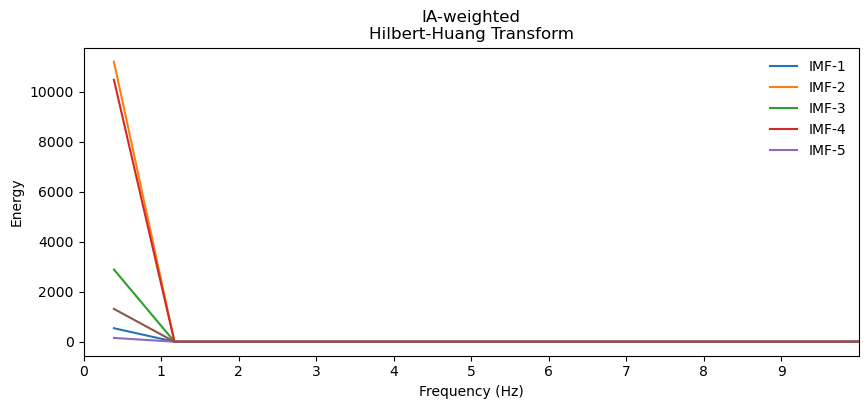

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(freq_centres, spec_weighted)
plt.xticks(np.arange(10))
plt.xlim(0, 10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy')
plt.title('IA-weighted\nHilbert-Huang Transform')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)